определим размеры шрифта по умолчанию, чтобы сделать фигуры красивее:

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# Классификация

## Загрузка набора MNIST

Следующий код извлекает набор данных MNIST с OpenML.org

In [3]:
from sklearn.datasets import fetch_openml 
 
mnist = fetch_openml('mnist_784', as_frame=False) 

In [4]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
X, y = mnist.data, mnist.target

In [6]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [8]:
X.shape, y.shape #28*28=784

((70000, 784), (70000,))

Есть 70 000 изображений, и каждое изображение имеет 784 функции. Это связано с тем, что каждое изображение имеет размер 28 × 28 пикселей, и каждая функция просто представляет интенсивность одного пикселя от 0 (белый) до 255 (черный).

Давайте взглянем на одну цифру из набора данных ( рис. 3-1 ). Все, что нам нужно сделать, это взять вектор признаков экземпляра, преобразовать его в массив 28 × 28 и отобразить его с помощью imshow() функции Matplotlib. Мы используем cmap="binary", чтобы получить карту цветов в оттенках серого, где 0 — белый, а 255 — черный: 

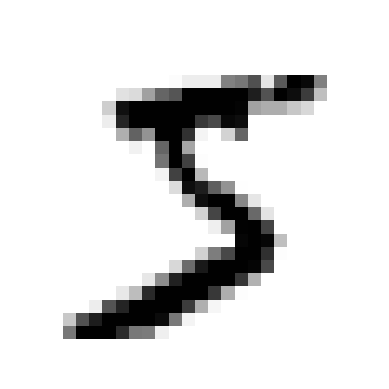

In [9]:
import matplotlib.pyplot as plt 
 
def plot_digit(image_data): 
    image = image_data.reshape(28, 28) #изменяем форму массива
    plt.imshow(image, cmap="binary") # отображаем данные в виде изображения
    plt.axis("off") 
 
some_digit = X[0] # чтобы посмотреть к какой цифре относится Х[0] необходимо вызвать у[0]
plot_digit(some_digit) 
plt.show() 

In [10]:
y[0]

'5'

Разделим набор на обучающую и тестовую выборки:

In [11]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:] 
#обучающий набор 60000, тестовый набор 10000 изображений

Обучающий набор уже перемешан для нас, и это хорошо, потому что это гарантирует, что все складки перекрестной проверки будут похожими (мы не хотим, чтобы в одном сгибе отсутствовали некоторые цифры). Более того, некоторые алгоритмы обучения чувствительны к порядку обучающих экземпляров и плохо работают, если получают много похожих экземпляров подряд.

## Обучение бинарного классификатора

Давайте пока упростим задачу и попробуем определить только одну цифру, например, цифру 5. Этот «5-детектор» будет примером бинарного классификатора , способного различать только два класса, 5 и не-5. Сначала мы создадим целевые векторы для этой задачи классификации: 

In [12]:
y_train_5 = (y_train == '5')

In [13]:
y_test_5 = (y_test == '5')

Давайте создадим SGDClassifier и обучим его на всем тренировочном наборе: 

In [14]:
from sklearn.linear_model import SGDClassifier 
 
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train_5) 

SGDClassifier(random_state=42)

In [15]:
sgd_clf.predict([some_digit])
#Классификатор предполагает, что это изображение представляет собой 5

array([ True])

## Измерение точности с помощью перекрестной проверки 

In [16]:
from sklearn.model_selection import cross_val_score 
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

Сравним с константным классификатором:

In [17]:
from sklearn.dummy import DummyClassifier 
 
dummy_clf = DummyClassifier() 
dummy_clf.fit(X_train, y_train_5) 
print(any(dummy_clf.predict(X_train)))

False


In [18]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90965, 0.90965, 0.90965])

Правильно, он имеет точность более 90%! Это просто потому, что только около 10% изображений имеют размер 5, поэтому, если вы всегда догадываетесь, что изображение не соответствует размеру 5, вы будете правы примерно в 90% случаев.

Гораздо лучший способ оценить производительность классификатора — посмотреть на матрицу путаницы (CM). 

Иногда вам потребуется больший контроль над процессом перекрестной проверки, чем то, что Scikit-Learn предоставляет в готовом виде. В этих случаях вы можете реализовать перекрестную проверку самостоятельно. Следующий код делает примерно то же самое, что и cross_val_score()функция Scikit-Learn, и выводит тот же результат: 

In [19]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone 
 
skfolds = StratifiedKFold(n_splits=3)  # shuffle = True, если набор данных еще не перемешан
                                        
for train_index, test_index in skfolds.split(X_train, y_train_5): 
    clone_clf = clone(sgd_clf) 
    X_train_folds = X_train[train_index] 
    y_train_folds = y_train_5[train_index] 
    X_test_fold = X_train[test_index] 
    y_test_fold = y_train_5[test_index] 
 
    clone_clf.fit(X_train_folds, y_train_folds) 
    y_pred = clone_clf.predict(X_test_fold) 
    n_correct = sum(y_pred == y_test_fold) 
    print(n_correct / len(y_pred)) 

0.95035
0.96035
0.9604


Класс StratifiedKFold выполняет стратифицированную выборку (как описано в главе 2 ) для создания складок, содержащих репрезентативное соотношение каждого класса. На каждой итерации код создает клон классификатора, обучает этот клон на обучающих сгибах и делает прогнозы на тестовых сгибах. Затем он подсчитывает количество правильных прогнозов и выводит соотношение правильных прогнозов. 

Как и cross_val_score() функция, cross_val_predict() выполняет k -кратную перекрестную проверку, но вместо того, чтобы возвращать оценочные баллы, она возвращает прогнозы, сделанные на каждом тестовом сверте. Это означает, что вы получаете чистый прогноз для каждого экземпляра в обучающем наборе (под «чистым» я подразумеваю «вне выборки»: модель делает прогнозы на основе данных, которые она никогда не видела во время обучения): 

In [20]:
from sklearn.model_selection import cross_val_predict 
 
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3) 

Теперь вы готовы получить матрицу путаницы с помощью confusion_matrix() функции. Просто передайте ему целевые классы ( y_train_5) и прогнозируемые классы ( y_train_pred): 

In [21]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(y_train_5, y_train_pred) 
cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

Каждая строка в матрице путаницы представляет фактический класс , а каждый столбец представляет предсказанный класс. 

- В первой строке этой матрицы рассматриваются изображения, отличные от 5 ( отрицательный класс ): 53 892 из них были правильно классифицированы как отличные от 5 (они называются истинными негативами ), а остальные 687 были ошибочно классифицированы как 5 ( ложноположительные , также называемые ошибки первого рода ). 

- Во втором ряду рассматриваются изображения пятерок (положительный класс ): 1891 изображение было ошибочно классифицировано как отличное от пятерки ( ложноотрицательные , также называемые ошибками второго рода ), а остальные 3530 были правильно классифицированы как пятерки ( истинно положительные ).

## Оценка модели 

### Precision, recall

In [22]:
from sklearn.metrics import precision_score, recall_score 
precision_score(y_train_5, y_train_pred)  # == 3530 / (687 + 3530) 

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530) 

0.6511713705958311

Теперь наш 5-детектор не выглядит таким блестящим, как когда мы смотрели на его точность. Когда он утверждает, что изображение представляет собой 5, это верно только в 83,7% случаев. Более того, он обнаруживает только 65,1% пятерок. 

Часто бывает удобно объединить точность и полноту в одну метрику, называемую оценкой F 1.

Показатель F 1 представляет собой гармоническое среднее точности и полноты. В то время как обычное среднее обрабатывает все значения одинаково, гармоническое среднее придает гораздо больший вес низким значениям. В результате классификатор получит высокий балл F 1 только в том случае, если и полнота, и точность будут высокими. 

In [24]:
from sklearn.metrics import f1_score 
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Вместо вызова метода классификатора predict()вы можете вызвать его decision_function()метод, который возвращает оценку для каждого экземпляра, а затем использовать любой порог, который вы хотите сделать для прогнозов на основе этих оценок: 

In [25]:
y_scores = sgd_clf.decision_function([some_digit]) 
print(y_scores)
threshold = 0 

[2164.22030239]


In [26]:
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

Поднимем порог:

In [27]:
threshold = 3000 
y_some_digit_pred = (y_scores > threshold) 
y_some_digit_pred

array([False])

Как вы решаете, какой порог использовать? Сначала используйте cross_val_predict()функцию, чтобы получить оценки всех экземпляров в обучающем наборе, но на этот раз укажите, что вы хотите возвращать оценки решений вместо прогнозов:

In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, 
                             method="decision_function") 

In [29]:
from sklearn.metrics import precision_recall_curve 
 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores) 

Покажем порог в 3000, который мы выбрали: 

In [30]:
import matplotlib.pyplot as plt

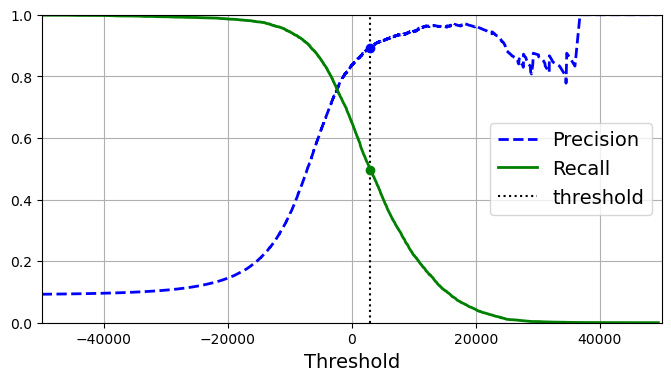

In [31]:
plt.figure(figsize=(8, 4)) 
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")


plt.show()

Еще один способ выбрать хороший компромисс между точностью и полнотой — построить график точности непосредственно в зависимости от полноты:

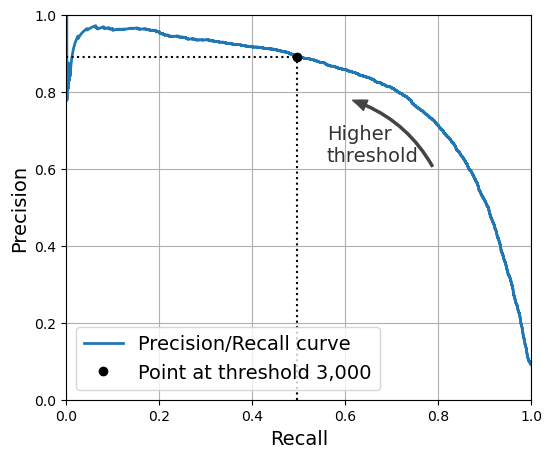

In [32]:
import matplotlib.patches as patches #для изогнутой стрелки
plt.figure(figsize=(6, 5))
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve") 

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show() 

Предположим, вы решили стремиться к точности 90%. Вы можете использовать первый график, чтобы найти порог, который вам нужно использовать, но это не очень точно. В качестве альтернативы вы можете искать самый низкий порог, который дает вам точность не менее 90%. Для этого вы можете использовать метод массива NumPy argmax(). Это возвращает первый индекс максимального значения, что в данном случае означает первое True значение: 

In [33]:
idx_for_90_precision = (precisions >= 0.90).argmax() 
threshold_for_90_precision = thresholds[idx_for_90_precision] 
threshold_for_90_precision

3370.0194991439594

Чтобы делать прогнозы (на тренировочном наборе на данный момент), вместо вызова метода классификатора predict()вы можете запустить этот код: 

In [34]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision) 

In [35]:
precision_score(y_train_5, y_train_pred_90) 

0.9000345901072293

In [36]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90) 

In [37]:
recall_at_90_precision

0.4799852425751706

## Кривая ROC

In [38]:
from sklearn.metrics import roc_curve 
 
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores) 

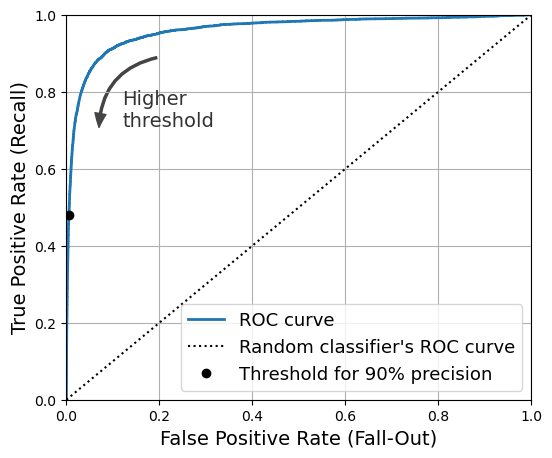

In [39]:
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax() 
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90] 

plt.figure(figsize=(6, 5))

plt.plot(fpr, tpr, linewidth=2, label="ROC curve") 
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve") 
plt.plot([fpr_90], [tpr_90], "ko", label="Threshold for 90% precision") 

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.20, 0.89), (0.07, 0.70),
    connectionstyle="arc3,rad=.4",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.12, 0.71, "Higher\nthreshold", color="#333333")
plt.xlabel('False Positive Rate (Fall-Out)')
plt.ylabel('True Positive Rate (Recall)')
plt.grid()
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right", fontsize=13) 

plt.show() 

Кривая ROC, отображающая частоту ложноположительных результатов в сравнении с частотой истинных положительных результатов для всех возможных пороговых значений; черный кружок выделяет выбранное соотношение (с точностью 90% и полнотой 48%). 

Одним из способов сравнения классификаторов является измерение площади под кривой (AUC).Совершенный классификатор будет иметь ROC AUC, равный 1, тогда как чисто случайный классификатор будет иметь ROC AUC, равный 0,5. Scikit-Learn предоставляет функцию для оценки ROC AUC: 

In [40]:
from sklearn.metrics import roc_auc_score 
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Давайте теперь создадим RandomForestClassifier, чью кривую PR и показатель F 1 мы можем сравнить с кривыми SGDClassifier: 

In [41]:
from sklearn.ensemble import RandomForestClassifier 
 
forest_clf = RandomForestClassifier(random_state=42) 

Мы можем вызвать cross_val_predict() функцию для обучения RandomForestClassifier и заставить ее предсказывать вероятности класса для каждого изображения следующим образом: 

In [42]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method="predict_proba") 

Давайте посмотрим на вероятности классов для первых двух изображений в обучающем наборе: 

In [43]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

In [44]:
y_scores_forest = y_probas_forest[:, 1] #Второй столбец содержит оценочные вероятности для положительного класса
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve( 
    y_train_5, y_scores_forest) 

Теперь мы готовы построить кривую PR:

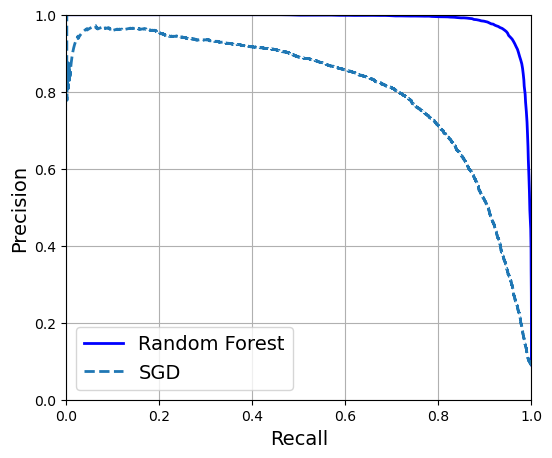

In [45]:
plt.figure(figsize=(6, 5)) 
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, 
         label="Random Forest") 
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD") 
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show() 

RandomForestClassifier кривая PR  выглядит намного лучше, чем для SGDClassifier: она подходит гораздо ближе к верхнему правому углу.

In [46]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5  # positive proba ≥ 50% 
f1_score(y_train_5, y_train_pred_forest) 

0.9274509803921569

In [47]:
roc_auc_score(y_train_5, y_scores_forest) 

0.9983436731328145

In [48]:
precision_score(y_train_5, y_train_pred_forest)

0.9897468089558485

In [49]:
recall_score(y_train_5, y_train_pred_forest)

0.8725327430363402

## Мультиклассовая классификация 

Используем sklearn.svm.SVC класс. Мы будем тренироваться только на первых 2000 изображений, иначе это займет очень много времени:

In [50]:
from sklearn.svm import SVC 
 
svm_clf = SVC(random_state=42) 
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5 

SVC(random_state=42)

In [51]:
svm_clf.predict([some_digit])
# Этот код на самом деле сделал 45 прогнозов — по одному на пару классов — и выбрал класс, выигравший наибольшее количество дуэлей.

array(['5'], dtype=object)

In [52]:
some_digit_scores = svm_clf.decision_function([some_digit]) 
some_digit_scores.round(2) 

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

Самый высокий балл — 9,3, и он действительно соответствует 5 классу: 

In [53]:
class_id = some_digit_scores.argmax() 
class_id

5

Когда классификатор обучен, он сохраняет список целевых классов в своем classes_ атрибуте, упорядоченном по значению. В случае MNIST индекс каждого класса в массиве classes_ удобно совпадает с самим классом (например, класс с индексом 5 оказывается class '5'):

In [54]:
svm_clf.classes_ 

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [55]:
svm_clf.classes_[class_id]

'5'

Если вы хотите заставить Scikit-Learn использовать стратегии один против одного или один против остальных, вы можете использовать классы OneVsOneClassifier или OneVsRestClassifier. 

In [56]:
from sklearn.multiclass import OneVsRestClassifier 
 
ovr_clf = OneVsRestClassifier(SVC(random_state=42)) 
ovr_clf.fit(X_train[:2000], y_train[:2000]) 

OneVsRestClassifier(estimator=SVC(random_state=42))

Сделаем прогноз и проверим количество обученных классификаторов: 

In [57]:
ovr_clf.predict([some_digit]) 
len(ovr_clf.estimators_)

10

Обучить SGDClassifier мультиклассовый набор данных и использовать его для прогнозирования так же просто: 

In [58]:
sgd_clf = SGDClassifier(random_state=42) 
sgd_clf.fit(X_train, y_train) 
sgd_clf.predict([some_digit]) #X[0]=5, модель ошиблась

array(['3'], dtype='<U1')

In [59]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

Конечно, вы захотите оценить этот классификатор более чем на одном изображении. Поскольку в каждом классе примерно одинаковое количество изображений, метрика точности в порядке. Как обычно, вы можете использовать cross_val_score() функцию для оценки модели: 

In [60]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.87365, 0.85835, 0.8689 ])

Простое масштабирование входных данных увеличивает точность выше 89,1%:

In [61]:
from sklearn.preprocessing import StandardScaler 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype("float64")) 
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

## Анализ ошибок для мультиклассового классификатора

Вместо матрицы путаницы используют цветную диаграмму матрицы, ее гораздо легче анализировать. Чтобы построить такую диаграмму, используйте ConfusionMatrixDisplay.from_predictions(): 

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay 
 
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3) 

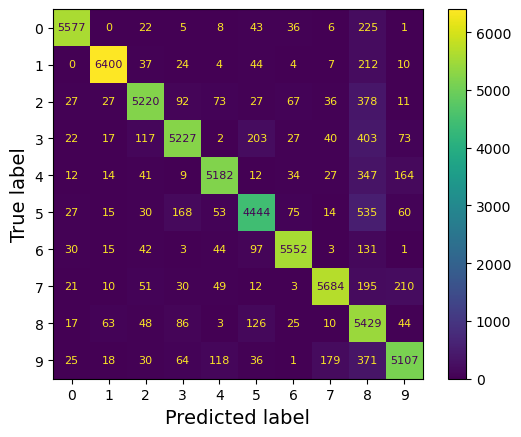

In [63]:
plt.rc('font', size=8)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred) 
plt.show() 

Обратите внимание, что ячейка по диагонали в строке № 5 и столбце № 5 выглядит немного темнее, чем другие цифры. Это может быть связано с тем, что модель допустила больше ошибок с пятерками, или с тем, что пятерок в наборе данных меньше, чем других цифр. Вот почему важно нормализовать матрицу путаницы, разделив каждое значение на общее количество изображений в соответствующем (истинном) классе (т. е. разделив на сумму строк). Это можно сделать просто установив normalize="true". Мы также можем указать values_format=".0%" аргумент, чтобы показать проценты без десятичных знаков.

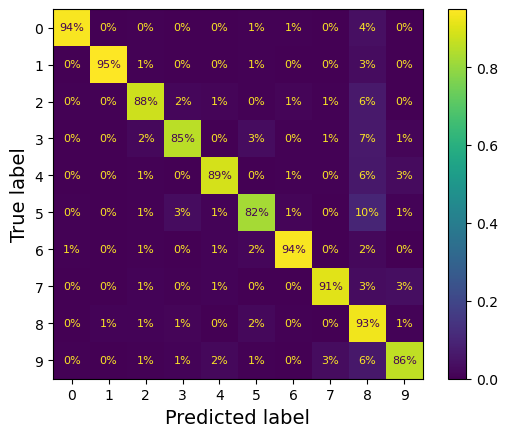

In [64]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        normalize="true", values_format=".0%") 
plt.rc('font', size=8)
plt.show()

Если вы хотите, чтобы ошибки выделялись больше, попробуйте присвоить нулевой вес правильным прогнозам:

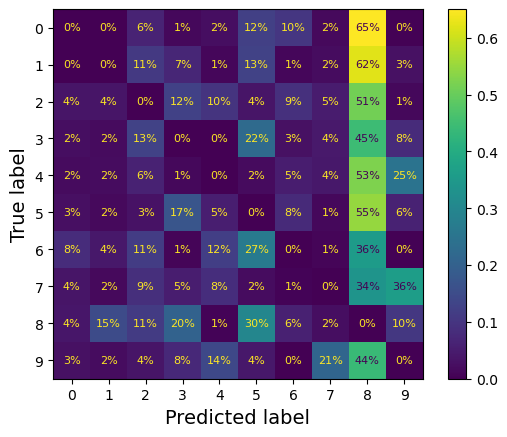

In [65]:
sample_weight = (y_train_pred != y_train) 
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        sample_weight=sample_weight, 
                                        normalize="true", values_format=".0%") 
plt.rc('font', size=12)
plt.show() 

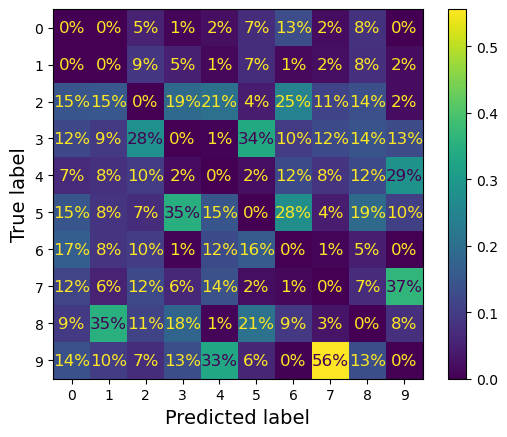

In [66]:
# можно нормализовать матрицу путаницы по столбцам, а не по строкам:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        sample_weight=sample_weight, 
                                        normalize="pred", values_format=".0%") 
plt.rc('font', size=6)
plt.show() 

Анализ отдельных ошибок также может быть хорошим способом получить представление о том, что делает ваш классификатор и почему он не работает. Например, давайте изобразим примеры троек и пятерок в стиле матрицы путаницы:

In [67]:
cl_a, cl_b = '3', '5' 
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)] 
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)] 
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)] 
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

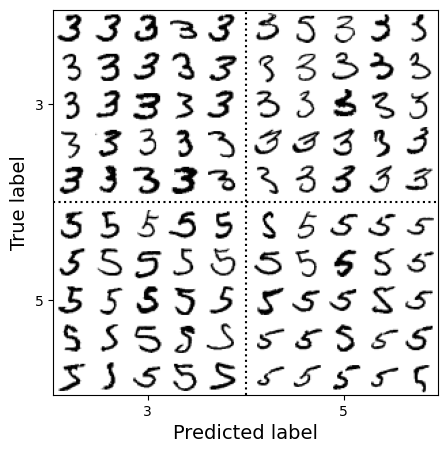

In [68]:
size = 5
pad = 0.2
plt.figure(figsize=(size, size))
for images, (label_col, label_row) in [(X_ba, (0, 0)), (X_bb, (1, 0)),
                                       (X_aa, (0, 1)), (X_ab, (1, 1))]:
    for idx, image_data in enumerate(images[:size*size]):
        x = idx % size + label_col * (size + pad)
        y = idx // size + label_row * (size + pad)
        plt.imshow(image_data.reshape(28, 28), cmap="binary",
                   extent=(x, x + 1, y, y + 1))
plt.xticks([size / 2, size + pad + size / 2], [str(cl_a), str(cl_b)])
plt.yticks([size / 2, size + pad + size / 2], [str(cl_b), str(cl_a)])
plt.plot([size + pad / 2, size + pad / 2], [0, 2 * size + pad], "k:")
plt.plot([0, 2 * size + pad], [size + pad / 2, size + pad / 2], "k:")
plt.axis([0, 2 * size + pad, 0, 2 * size + pad])
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()

Мы использовали простой SGDClassifier, которая представляет собой просто линейную модель: все, что она делает, — это назначает вес для каждого класса каждому пикселю, и когда она видит новое изображение, она просто суммирует взвешенные интенсивности пикселей, чтобы получить оценку для каждого класса. Поскольку 3 и 5 отличаются всего несколькими пикселями, эта модель легко их спутает. 

## Многоуровневая классификация

In [69]:
import numpy as np 
from sklearn.neighbors import KNeighborsClassifier 
 
y_train_large = (y_train >= '7') 
y_train_odd = (y_train.astype('int8') % 2 == 1) 
y_multilabel = np.c_[y_train_large, y_train_odd] 
 
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train, y_multilabel) 

KNeighborsClassifier()

Этот код создает y_multilabel массив, содержащий две целевые метки для каждого изображения цифры: первая указывает, является ли цифра большой (7, 8 или 9), а вторая указывает, является ли она нечетной. Затем код создает KNeighborsClassifier экземпляр, который поддерживает классификацию с несколькими метками (не все классификаторы поддерживают), и обучает эту модель, используя массив множественных целей. Теперь вы можете сделать прогноз и заметить, что он выводит две метки: 

In [70]:
knn_clf.predict([some_digit]) # Цифра 5 действительно не большая ( False) и нечетная ( True). 

array([[False,  True]])

Следующий код вычисляет средний балл F 1 по всем меткам:

In [71]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3) 
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.976410265560605

Этот подход предполагает, что все метки одинаково важны, что может быть не так. В частности, если у вас гораздо больше изображений Алисы, чем Боба или Чарли, вы можете придать больший вес оценке классификатора для изображений Алисы. Один простой вариант — присвоить каждой метке вес, равный ее поддержке (т. е. количеству экземпляров с этой целевой меткой). Для этого просто установите average="weighted" при вызове f1_score() функции

Если вы хотите использовать классификатор, который изначально не поддерживает классификацию с несколькими метками, например SVC, одной из возможных стратегий является обучение одной модели для каждой метки. В Scikit-Learn есть класс ChainClassifier, который делает именно это!

In [72]:
from sklearn.multioutput import ClassifierChain 
 
chain_clf = ClassifierChain(SVC(), cv=3, random_state=42) 
chain_clf.fit(X_train[:2000], y_multilabel[:2000]) 

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

Теперь мы можем использовать ChainClassifier, чтобы делать прогнозы: 

In [73]:
chain_clf.predict([some_digit])

array([[0., 1.]])

## Многовыходная классификация

Это обобщение классификации с несколькими метками, где каждая метка может быть мультиклассовой (т. е. может иметь более двух возможных значений)

Давайте начнем с создания обучающих и тестовых наборов, взяв изображения MNIST и добавив шум к их интенсивности пикселей с помощью randint()функции NumPy. Целевыми изображениями будут исходные изображения: 

In [74]:
np.random.seed(42)  # чтобы сделать этот пример кода воспроизводимым
noise = np.random.randint(0, 100, (len(X_train), 784)) 
X_train_mod = X_train + noise 
noise = np.random.randint(0, 100, (len(X_test), 784)) 
X_test_mod = X_test + noise 
y_train_mod = X_train 
y_test_mod = X_test 

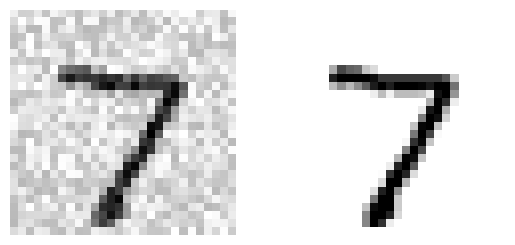

In [75]:
plt.subplot(121); plot_digit(X_test_mod[0])
plt.subplot(122); plot_digit(y_test_mod[0])

plt.show()

Теперь давайте обучим классификатор и заставим его очищать это изображение:

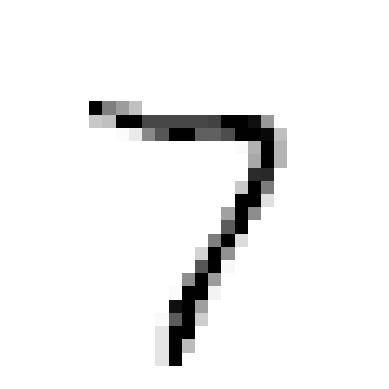

In [76]:
knn_clf = KNeighborsClassifier() 
knn_clf.fit(X_train_mod, y_train_mod) 
clean_digit = knn_clf.predict([X_test_mod[0]]) 
plot_digit(clean_digit) 
plt.show() 

# ПРАКТИКА

## Задание №1:

Попробуйте создать классификатор для набора данных MNIST, который достигает точности более 97% на тестовом наборе. Подсказка: KNeighborsClassifier вполне подходит для этой задачи; вам просто нужно найти хорошие значения гиперпараметров (попробуйте поиск по сетке по гиперпараметрам weights и n_neighbors). 


Давайте начнем с простого классификатора K-ближайших соседей и измерим его производительность на тестовом наборе. Это будет наша основа:

In [77]:
clf_kn = KNeighborsClassifier()
clf_kn.fit(X_train, y_train)
baseline_accaracy = clf_kn.score(X_test, y_test)
baseline_accaracy

0.9688

Давайте посмотрим, может ли помочь настройка гиперпараметров. Для ускорения поиска потренируемся только на первых 10 000 изображений:

In [78]:
from sklearn.model_selection import GridSearchCV
param =[{'weights':["uniform", "distance"], 'n_neighbors':[3,4,5,6]}]
clf_cv = GridSearchCV(clf_kn, cv=5, param_grid=param)
clf_cv.fit(X_train[:10000], y_train[:10000])

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid=[{'n_neighbors': [3, 4, 5, 6],
                          'weights': ['uniform', 'distance']}])

In [79]:
clf_cv.best_params_

{'n_neighbors': 4, 'weights': 'distance'}

In [80]:
clf_cv.best_score_

0.9441999999999998

Оценка упала, но это было ожидаемо, поскольку мы тренировались только на 10 000 изображений. Итак, давайте возьмем лучшую модель и снова обучим ее на полном тренировочном наборе:

In [81]:
clf_cv.best_estimator_.fit(X_train, y_train)
tunned_accuracy = clf_cv.score(X_test, y_test)
tunned_accuracy

0.9714

Мы достигли нашей цели - точности 97%!

## Задача №2:

Напишите функцию, которая может сдвигать изображение MNIST в любом направлении (влево, вправо, вверх или вниз) на один пиксель.⁠ Затем для каждого изображения в обучающем наборе создайте четыре сдвинутые копии (по одной в каждом направлении) и добавьте их к тренировочному набору. Наконец, обучите свою лучшую модель на этом расширенном обучающем наборе и измерьте ее точность на тестовом наборе. Вы должны заметить, что ваша модель теперь работает еще лучше!Этот метод искусственного увеличения обучающей выборки называется увеличением данных или расширением обучающей выборки . 

In [82]:
# осуществим сдвиг массива:
from scipy.ndimage import shift

In [83]:
def image_shift(image, dx, dy):
    image = image.reshape((28,28)) # придаем новую форму массиву
    shift_image = shift(image, [dy, dx], cval=0, mode='constant')
    return shift_image.reshape([-1]) # сдвиг массива на один пиксель

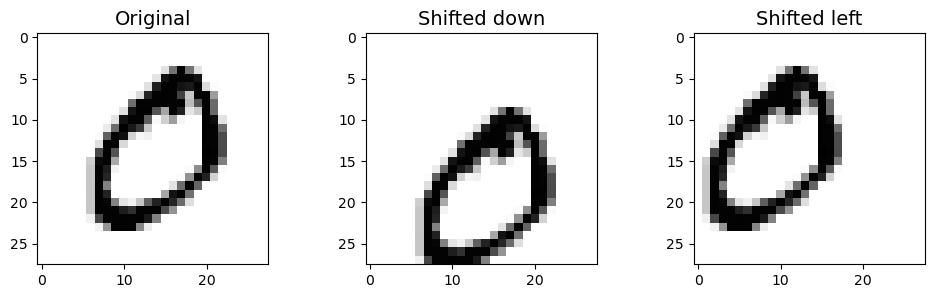

In [84]:
image = X_train[1]  # случайный объект для демонстрации
shifted_image_down = image_shift(image, 0, 5)
shifted_image_left = image_shift(image, -5, 0)

plt.figure(figsize=(12, 3))
plt.subplot(131)
plt.title("Original")
plt.imshow(image.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(132)
plt.title("Shifted down")
plt.imshow(shifted_image_down.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.subplot(133)
plt.title("Shifted left")
plt.imshow(shifted_image_left.reshape(28, 28),
           interpolation="nearest", cmap="Greys")
plt.show()

Выглядит неплохо! Теперь давайте создадим расширенный обучающий набор, сдвинув каждое изображение влево, вправо, вверх и вниз на один пиксель:

In [85]:
X_train_augmented = [image for image in X_train]
y_train_augmented = [label for label in y_train]

In [86]:
for dx, dy in ((-1, 0), (1, 0), (0, 1), (0, -1)): # сдвигаем пиксели
    for image, label in zip(X_train, y_train):
        X_train_augmented.append(image_shift(image, dx, dy))
        y_train_augmented.append(label)

# Функция zip()возвращает zip-объект, который является итератором кортежей, где первый элемент в каждом переданном итераторе соединяется вместе, 
# а затем второй элемент в каждом переданном итераторе соединяется вместе и т. д.

In [87]:
# получаем новые массивы с данными
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)


Перетасуем расширенный обучающий набор, иначе все сдвинутые изображения будут сгруппированы вместе:

In [88]:
shuffle_idx = np.random.permutation(len(X_train_augmented)) # возвращает одномерный массив целых чисел, 
# содержащий случайную перестановку чисел от 0 до len(X_train_augmented) - 1.
# Затем этот перетасованный массив индексов используется для переупорядочения строк массивов:
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

Теперь давайте обучим модель, используя лучшие гиперпараметры, которые мы нашли в предыдущем упражнении:

In [90]:
knn_clf = KNeighborsClassifier(**clf_cv.best_params_)

In [91]:
knn_clf.fit(X_train_augmented, y_train_augmented)
augmented_accuracy = knn_clf.score(X_test, y_test)
augmented_accuracy

0.9763

Просто увеличивая данные, мы получаем повышение точности на 0,5%. Возможно, это звучит не так впечатляюще, но на самом деле это означает, что процент ошибок значительно снизился:

In [92]:
error_rate_change = (1-augmented_accuracy)/(1-tunned_accuracy)-1
print(f"error_rate_change = {error_rate_change:.0%}")

error_rate_change = -17%


## Задание №3:

Создайте классификатор спама. 

### 3.1 Загрузите примеры спама из общедоступных наборов данных Apache SpamAssassin . 

In [93]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def fetch_spam_data():
    spam_root = "http://spamassassin.apache.org/old/publiccorpus/"
    ham_url = spam_root + "20030228_easy_ham.tar.bz2"
    spam_url = spam_root + "20030228_spam.tar.bz2"

    spam_path = Path() / "datasets" / "spam"
    spam_path.mkdir(parents=True, exist_ok=True)
    for dir_name, tar_name, url in (("easy_ham", "ham", ham_url),
                                    ("spam", "spam", spam_url)):
        if not (spam_path / dir_name).is_dir():
            path = (spam_path / tar_name).with_suffix(".tar.bz2")
            print("Downloading", path)
            urllib.request.urlretrieve(url, path)
            tar_bz2_file = tarfile.open(path)
            tar_bz2_file.extractall(path=spam_path)
            tar_bz2_file.close()
    return [spam_path / dir_name for dir_name in ("easy_ham", "spam")]

Это функция Python, которая извлекает данные о спаме с веб-сайта общедоступного корпуса SpamAssassin. Функция загружает два сжатых файла, содержащих сообщения электронной почты, один со спам-сообщениями и один с сообщениями, не являющимися спамом (ветхозаветными). Затем он извлекает файлы в отдельные каталоги и возвращает список путей к извлеченным каталогам.

Функция использует Pathмодуль для создания Pathобъекта, представляющего корневой каталог, в котором будут храниться спам-данные. Он создает каталог, если он еще не существует. Затем функция перебирает два кортежа, каждый из которых содержит имя каталога, в который следует извлечь сообщения, имя сжатого файла и URL-адрес, из которого нужно загрузить сжатый файл.

Для каждого кортежа функция проверяет, существует ли уже целевой каталог. Если это не так, он создает Pathобъект, представляющий путь к сжатому файлу, и использует urllib.request.urlretrieveего для загрузки с указанного URL-адреса. Затем функция создает tarfile.TarFileобъект, представляющий сжатый файл, и использует свой extractallметод для извлечения всех файлов из сжатого файла в целевой каталог. Наконец, он закрывает TarFileобъект.

Функция возвращает список, содержащий два Pathобъекта, представляющих каталоги, содержащие спам и нежелательные сообщения соответственно. Эти каталоги создаются внутри spamкаталога, ранее созданного функцией.

In [94]:
ham_dir, spam_dir = fetch_spam_data()

Далее давайте загрузим все электронные письма:

In [95]:
ham_filenames = [f for f in sorted(ham_dir.iterdir()) if len(f.name) > 20]
spam_filenames = [f for f in sorted(spam_dir.iterdir()) if len(f.name) > 20]
# генератор списка выбирает все файлы в каталоге, имена которых длиннее 20 символов, и сортирует их в алфавитном порядке
# это делается для того, чтобы исключить любые файлы метаданных или другие файлы, 
# не относящиеся к электронной почте, которые могут присутствовать в каталоге.

In [96]:
len(ham_filenames)

2500

In [97]:
len(spam_filenames)

500

Мы можем использовать модуль электронной почты Python для анализа этих писем (он обрабатывает заголовки, кодировку и т. д.):

In [98]:
import email
import email.policy

def load_email(filepath):
    with open(filepath, "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

Это функция Python, которая загружает сообщение электронной почты из файла по указанному пути к файлу.

Модуль emailпредставляет собой встроенный в Python модуль, предоставляющий функциональные возможности для работы с сообщениями электронной почты. Подмодуль parserвнутри emailмодуля предоставляет функциональные возможности для разбора сообщений электронной почты из строк или файлов.

Функция load_emailпринимает путь к файлу в качестве входных данных, открывает файл в двоичном режиме с помощью withоператора, а затем использует BytesParserкласс из parserподмодуля для анализа сообщения электронной почты из файла. Класс BytesParserиспользуется для анализа сообщений электронной почты из байтовых объектов, таких как файлы, открытые в двоичном режиме.

Аргумент policy=email.policy.default, передаваемый конструктору, BytesParserуказывает политику, используемую при анализе сообщения электронной почты. В этом случае используется политика default, которая применяет набор правил по умолчанию для разбора сообщений электронной почты, предназначенных для защиты от распространенных угроз безопасности электронной почты.

Наконец, функция возвращает проанализированный объект сообщения электронной почты load_email.

In [99]:
ham_emails = [load_email(filepath) for filepath in ham_filenames]
spam_emails = [load_email(filepath) for filepath in spam_filenames]

Давайте рассмотрим один пример письма и один пример спама, чтобы понять, как выглядят данные:

In [100]:
print(ham_emails[1].get_content().strip())
# будет печатать содержимое второго сообщения электронной почты после удаления всех начальных или конечных пробелов. 
# Этот get_content()метод используется для извлечения содержимого сообщения электронной почты в виде строки, 
# а также strip()для удаления любых начальных или конечных пробельных символов из этой строки.

Martin A posted:
Tassos Papadopoulos, the Greek sculptor behind the plan, judged that the
 limestone of Mount Kerdylio, 70 miles east of Salonika and not far from the
 Mount Athos monastic community, was ideal for the patriotic sculpture. 
 
 As well as Alexander's granite features, 240 ft high and 170 ft wide, a
 museum, a restored amphitheatre and car park for admiring crowds are
planned
---------------------
So is this mountain limestone or granite?
If it's limestone, it'll weather pretty fast.

------------------------ Yahoo! Groups Sponsor ---------------------~-->
4 DVDs Free +s&p Join Now
http://us.click.yahoo.com/pt6YBB/NXiEAA/mG3HAA/7gSolB/TM
---------------------------------------------------------------------~->

To unsubscribe from this group, send an email to:
forteana-unsubscribe@egroups.com

 

Your use of Yahoo! Groups is subject to http://docs.yahoo.com/info/terms/


In [101]:
print(spam_emails[1].get_content().strip())

1) Fight The Risk of Cancer!
http://www.adclick.ws/p.cfm?o=315&s=pk007

2) Slim Down - Guaranteed to lose 10-12 lbs in 30 days
http://www.adclick.ws/p.cfm?o=249&s=pk007

3) Get the Child Support You Deserve - Free Legal Advice
http://www.adclick.ws/p.cfm?o=245&s=pk002

4) Join the Web's Fastest Growing Singles Community
http://www.adclick.ws/p.cfm?o=259&s=pk007

5) Start Your Private Photo Album Online!
http://www.adclick.ws/p.cfm?o=283&s=pk007

Have a Wonderful Day,
Offer Manager
PrizeMama













If you wish to leave this list please use the link below.
http://www.qves.com/trim/?ilug@linux.ie%7C17%7C114258


-- 
Irish Linux Users' Group: ilug@linux.ie
http://www.linux.ie/mailman/listinfo/ilug for (un)subscription information.
List maintainer: listmaster@linux.ie


Некоторые электронные письма на самом деле состоят из нескольких частей, с изображениями и вложениями (которые могут иметь свои собственные вложения). Давайте посмотрим на различные типы структур, которые у нас есть:

In [102]:
def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        multipart = ", ".join([get_email_structure(sub_email)
                               for sub_email in payload])
        return f"multipart({multipart})"
    else:
        return email.get_content_type()

Данная функция Python get_email_structureпринимает объект электронной почты или строку в качестве входных данных и рекурсивно возвращает структуру электронной почты. Если ввод является строкой, он возвращает строку как есть. Если ввод является объектом электронной почты, он проверяет, состоит ли электронная почта из нескольких частей, и если да, то рекурсивно вызывает функцию для каждой части и возвращает строку, указывающую, что это электронная почта, состоящая из нескольких частей. Если электронное письмо состоит только из одной части, возвращается тип содержимого этой части.

Функция предполагает, что входной объект электронной почты имеет get_payload()метод, который возвращает либо строку, либо список объектов электронной почты. Также предполагается, что у каждого объекта электронной почты есть get_content_type()метод, который возвращает строку, представляющую тип содержимого электронной почты.

Обратите внимание, что эта функция не обрабатывает все возможные случаи структур электронной почты, так как могут быть более сложные структуры электронной почты, которые включают вложенные составные части или вложения.

In [103]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

Данная функция Python structures_counter принимает список объектов электронной почты или строк в качестве входных данных и возвращает объект Counter, который подсчитывает, сколько раз каждая структура электронной почты появляется в списке.

Сначала функция создает пустой Counter объект, вызываемый structures для хранения счетчиков. Затем он выполняет итерацию по каждому электронному письму в списке ввода и для каждого электронного письма вызывает функцию, get_email_structure чтобы получить его структуру. Затем он увеличивает количество этой структуры в structures счетчике.

Наконец, функция возвращает structures счетчик, который содержит количество каждой структуры электронной почты во входном списке.

Обратите внимание, что эта функция опирается на get_email_structure ранее определенную функцию, которая рекурсивно вычисляет структуру объекта электронной почты или строки.

In [104]:
structures_counter(ham_emails).most_common()
# вернет список кортежей, где каждый кортеж содержит структуру электронного письма в списке вместе с количеством вхождений этой структуры в списке. 
# Список будет отсортирован в порядке убывания количества вхождений, так что наиболее распространенная структура будет первой.

[('text/plain', 2408),
 ('multipart(text/plain, application/pgp-signature)', 66),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [105]:
structures_counter(spam_emails).most_common()

[('text/plain', 218),
 ('text/html', 183),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 20),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

Теперь давайте посмотрим на заголовки писем:

In [106]:
for header, value in spam_emails[0].items():
    print(header, ":", value)
# items() это метод, который возвращает список пар словаря (в данном случае электронной почты) (ключ, значение) в виде кортежей.
# Цикл for перебирает каждый из этих кортежей и присваивает ключ header и значение value.

Return-Path : <12a1mailbot1@web.de>
Delivered-To : zzzz@localhost.spamassassin.taint.org
Received : from localhost (localhost [127.0.0.1])	by phobos.labs.spamassassin.taint.org (Postfix) with ESMTP id 136B943C32	for <zzzz@localhost>; Thu, 22 Aug 2002 08:17:21 -0400 (EDT)
Received : from mail.webnote.net [193.120.211.219]	by localhost with POP3 (fetchmail-5.9.0)	for zzzz@localhost (single-drop); Thu, 22 Aug 2002 13:17:21 +0100 (IST)
Received : from dd_it7 ([210.97.77.167])	by webnote.net (8.9.3/8.9.3) with ESMTP id NAA04623	for <zzzz@spamassassin.taint.org>; Thu, 22 Aug 2002 13:09:41 +0100
From : 12a1mailbot1@web.de
Received : from r-smtp.korea.com - 203.122.2.197 by dd_it7  with Microsoft SMTPSVC(5.5.1775.675.6);	 Sat, 24 Aug 2002 09:42:10 +0900
To : dcek1a1@netsgo.com
Subject : Life Insurance - Why Pay More?
Date : Wed, 21 Aug 2002 20:31:57 -1600
MIME-Version : 1.0
Message-ID : <0103c1042001882DD_IT7@dd_it7>
Content-Type : text/html; charset="iso-8859-1"
Content-Transfer-Encoding : qu

Вероятно, там есть много полезной информации, например, адрес электронной почты отправителя (12a1mailbot1@web.de выглядит подозрительно), но мы просто сосредоточимся на заголовке Subject:

In [107]:
spam_emails[0]["Subject"]

'Life Insurance - Why Pay More?'

In [108]:
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(ham_emails+spam_emails, dtype=object)
y = np.array([0]*len(ham_emails)+[1]*len(spam_emails))
# X будет содержать текст каждого электронного письма, а y соответствующие метки (0 для ham и 1 для spam).

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42, stratify=y)

Следующая функция сначала удаляет раздел head, затем преобразует все теги 'a' в слово HYPERLINK, затем избавляется от всех тегов HTML, оставляя только обычный текст. Для удобочитаемости он также заменяет несколько новых строк одиночными новыми строками и, наконец, не экранирует html-элементы:

In [110]:
import re
from html import unescape

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

Давайте посмотрим, работает ли это. Это HTML-спам:

In [111]:
html_spam_emails = [email for email in X_train[y_train==1]
                    if get_email_structure(email) == "text/html"]
# Список содержит все электронные письма в обучающем наборе X_train где соответствующая метка y_train равна 1. 
# структура электронной почты идентифицируется как «текст/html» с помощью функции, называемой get_email_structure()
sample_html_spam = html_spam_emails[7]
print(sample_html_spam.get_content().strip()[:1000], "...")
#  печатает содержимое объекта sample_html_spamэлектронной почты после удаления всех 
# начальных или конечных пробелов и выбора первых 1000 символов содержимого, за которыми следует многоточие.

<HTML>
<HEAD>
</HEAD>
<BODY>
<FONT SIZE="4"><B> A man endowed with a 7 - 8" hammer is simply<br>
 better equipped than a man with a 5 - 6" hammer. <BR>
<BR>Would you rather have<br>more than enough to get the job done or fall very short. It's totally up<br>to you. Our Methods are guaranteed to increase your size by 1 - 3"<br> <A HREF="http://202.109.114.136/index.php?10004">Enter here and see how</A>
</BODY>
</HTML> ...


Получили очищенный текст:

In [112]:
print(html_to_plain_text(sample_html_spam.get_content())[:1000], "...")


 A man endowed with a 7 - 8" hammer is simply
 better equipped than a man with a 5 - 6" hammer.
Would you rather havemore than enough to get the job done or fall very short. It's totally upto you. Our Methods are guaranteed to increase your size by 1 - 3"  HYPERLINK Enter here and see how
 ...


Теперь давайте напишем функцию, которая принимает электронное письмо в качестве входных данных и возвращает его содержимое в виде простого текста, независимо от его формата:

In [113]:
def email_for_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"): # Сначала код просматривает каждую часть электронного письма, 
            # проверяя, является ли тип содержимого «текстовым/обычным» или «текстовым/html».
            continue
        try:
            content = part.get_content()
        except:
            content = str(part.get_payload())
        # Если тип контента не является одним из них, он переходит к следующей части электронного письма.
        if ctype == "text/plain":
            return content
        else:
            html = content 
        if html:
            return html_to_plain_text(html)

In [114]:
print(email_for_text(sample_html_spam)[:100], "...")


 A man endowed with a 7 - 8" hammer is simply
 better equipped than a man with a 5 - 6" hammer.
Wou ...


Давайте добавим немного стемминга! Мы будем использовать Natural Language Toolkit (NLTK):

In [115]:
import nltk

stemmer = nltk.PorterStemmer()
for word in ("Computations", "Computation", "Computing", "Computed", "Compute",
             "Compulsive"):
    print(word, "=>", stemmer.stem(word))
# Код перебирает список слов и для каждого слова применяет метод stem()объекта PorterStemmer, который возвращает версию слова с основой. 
# Основополагающая версия слова — это его основа или корневая форма, полученная путем удаления любых суффиксов.

Computations => comput
Computation => comput
Computing => comput
Computed => comput
Compute => comput
Compulsive => compuls


In [116]:
! pip install urlextract

Библиотека urlextract представляет собой библиотеку Python, которую можно использовать для извлечения URL-адресов из текста. Он предоставляет простой и эффективный способ анализа и извлечения URL-адресов из текстовых данных, который может быть полезен в различных приложениях, таких как просмотр веб-страниц, анализ текста и обработка естественного языка.

In [117]:
import urlextract 

url_extractor = urlextract.URLExtract()
some_text = "Will it detect github.com and https://youtu.be/7Pq-S557XQU?t=3m32s"
print(url_extractor.find_urls(some_text))

['github.com', 'https://youtu.be/7Pq-S557XQU?t=3m32s']


Этот код использует urlextract библиотеку для извлечения URL-адресов из заданного текста. Функция URLExtract() создает экземпляр класса URLExtract, который используется для извлечения URL-адресов. Метод find_urls() этого класса принимает текст в качестве входных данных и возвращает список URL-адресов, найденных в тексте.

В данном коде url_extractor объект создается с использованием URLExtract(). Затем find_urls() метод вызывается для some_text строки, которая содержит сочетание текста и URL-адресов. Ожидаемый результат — список URL-адресов, найденных в some_text строке.

In [119]:
from sklearn.base import BaseEstimator, TransformerMixin

class EmailToWordCounterTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True,
                 remove_punctuation=True, replace_urls=True,
                 replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_for_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls and url_extractor is not None:
                urls = list(set(url_extractor.find_urls(text)))
                urls.sort(key=lambda url: len(url), reverse=True)
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            word_counts = Counter(text.split())
            if self.stemming and stemmer is not None:
                stemmed_word_counts = Counter()
                for word, count in word_counts.items():
                    stemmed_word = stemmer.stem(word)
                    stemmed_word_counts[stemmed_word] += count
                word_counts = stemmed_word_counts
            X_transformed.append(word_counts)
        return np.array(X_transformed)

Этот код определяет пользовательский класс преобразователя EmailToWordCounterTransformer, который можно использовать в конвейере Scikit-learn для предварительной обработки электронных писем и подсчета вхождений каждого слова.

Метод __init__инициализирует преобразователь логическими переменными, указывающими, какие шаги предварительной обработки следует выполнить. Метод fitничего не делает и просто возвращает экземпляр преобразователя. Метод transformпредварительно обрабатывает каждое электронное письмо во входном массиве Xи возвращает массив словарей подсчета слов.

Шаги предварительной обработки, которые могут быть выполнены, включают:

Удаление заголовков из электронной почты.
Преобразование всего текста в нижний регистр.
Удаление знаков препинания.
Замена URL строкой "URL".
Замена всех чисел строкой «ЧИСЛО».
Приведение слов к их основной форме.
Метод transformобрабатывает каждое электронное письмо, используя указанные шаги предварительной обработки, и возвращает словарь, который сопоставляет каждое слово с его количеством в электронном письме. Если включено определение основы, вместо этого используется версия каждого слова с основой.

Этот преобразователь может быть полезен для задач классификации текста, где частота определенных слов в тексте может указывать на метку класса.

Давайте попробуем этот преобразователь на нескольких электронных письмах:

In [123]:
X_few = X_train[:3]
X_few_wordcounts = EmailToWordCounterTransformer().fit_transform(X_few)
X_few_wordcounts

array([Counter({'in': 6, 'of': 5, 'and': 5, 'the': 5, 'you': 5, 'r': 4, 'that': 3, 'i': 3, 'a': 3, 'eateri': 3, 'toronto': 3, 'are': 3, 'not': 3, 'com': 2, 't': 2, 'as': 2, 'have': 2, 'varieti': 2, 'good': 2, 'local': 2, 'strip': 2, 'but': 2, 'neighbourhood': 2, 'more': 2, 'than': 2, 'or': 2, 'there': 2, 'like': 2, 'can': 2, 'at': 2, 'doe': 2, 'live': 2, 'commun': 2, 'russel': 1, 'turpin': 1, 'deafbox': 1, 'hotmail': 1, 'write': 1, 'thing': 1, 'aren': 1, 'all': 1, 'bad': 1, 'rememb': 1, 'vancouv': 1, 'broad': 1, 'joint': 1, 'haven': 1, 'been': 1, 'to': 1, 'van': 1, 'year': 1, 'do': 1, 'know': 1, 'outsid': 1, 'small': 1, 'deepli': 1, 'ethnic': 1, 'if': 1, 'stray': 1, 'number': 1, 'feet': 1, 'from': 1, 'wellesley': 1, 'jarvi': 1, 'queen': 1, 'spadina': 1, 're': 1, 'doughnutland': 1, 's': 1, 'far': 1, 'eaton': 1, 'centr': 1, 'quaint': 1, 'cafe': 1, 'mccaul': 1, 'north': 1, 'dunda': 1, 'rare': 1, 'littl': 1, 'brim': 1, 'with': 1, 'lunchtim': 1, 'traffic': 1, 'still': 1, 'find': 1, 'seat': 

Теперь у нас есть количество слов, и нам нужно преобразовать их в векторы. Для этого мы создадим еще один преобразователь, чей метод fit() будет строить словарь (упорядоченный список наиболее распространенных слов), а чей метод transform() будет использовать словарь для преобразования количества слов в векторы. На выходе получается разреженная матрица.

In [124]:
from scipy.sparse import csr_matrix

class WordCounterToVectorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, vocabulary_size=1000): # это метод конструктора, который инициализирует vocabulary_sizeпараметр. Значение по умолчанию — 1000.
        self.vocabulary_size = vocabulary_size
    def fit(self, X, y=None): # этот метод вычисляет наиболее распространенные слова во всех документах в X, создает словарь, который 
        # сопоставляет каждое слово с индексом и сохраняет полученный словарь в атрибуте vocabulary_. Метод возвращает self.
        total_count = Counter()
        for word_count in X:
            for word, count in word_count.items():
                total_count[word] += min(count, 10)
        most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word: index + 1
                            for index, (word, count) in enumerate(most_common)}
        return self
    def transform(self, X, y=None): # этот метод использует словарь, хранящийся в vocabulary_атрибуте, для преобразования каждого 
        # документа X в разреженное матричное представление. Полученная матрица возвращается.
        rows = [] # одномерный массив индексов строки
        cols = [] # одномерный массив индексов столбца
        data = [] # одномерный массив значений, соответсвующих значениям в разряженной матрице
        for row, word_count in enumerate(X):
            for word, count in word_count.items():
                rows.append(row)
                cols.append(self.vocabulary_.get(word, 0))
                data.append(count)
        return csr_matrix((data, (rows, cols)),
                          shape=(len(X), self.vocabulary_size + 1))

В этом transform методе массивы rows, colsи data создаются путем итерации по каждому документу в X, и для каждого слова в документе к массивам добавляются соответствующий индекс строки, индекс столбца и значение счетчика. Результирующая разреженная матрица имеет одну строку для каждого документа и один столбец для каждого слова в словаре, а также дополнительный столбец для слов, которых нет в словаре. Значения в дополнительном столбце будут равны 0 для всех документов.

In [125]:
vocab_transformer = WordCounterToVectorTransformer(vocabulary_size=10) # трансформируем в матрицу 10 слов
X_few_vectors = vocab_transformer.fit_transform(X_few_wordcounts)
X_few_vectors # получилась разреженная матрица

<3x11 sparse matrix of type '<class 'numpy.intc'>'
	with 30 stored elements in Compressed Sparse Row format>

In [127]:
X_few_vectors.toarray() # матрица

array([[157,   1,   5,   1,   6,   5,   5,   5,   1,   1,   0],
       [106,  18,   6,  10,   4,   3,   0,   2,   4,   0,   5],
       [ 66,   2,   1,   1,   1,   1,   3,   1,   2,   5,   1]],
      dtype=int32)

Что означает эта матрица? 157 в первой строке, в первом столбце, означает, что первое электронное письмо содержит 157 слов, которые не являются частью словарного запаса. Число 1 рядом с ним означает, что первое слово словаря встречается в этом письме 1 раз. 5 рядом с ним означает, что второе слово присутствует 5 раз и так далее.

In [128]:
vocab_transformer.vocabulary_

{'number': 1,
 'and': 2,
 'url': 3,
 'in': 4,
 'you': 5,
 'of': 6,
 'the': 7,
 'to': 8,
 's': 9,
 'thi': 10}

Теперь мы готовы обучить наш первый классификатор спама! Преобразуем весь набор данных:

In [129]:
from sklearn.pipeline import Pipeline

preprocess_pipeline = Pipeline([
    ("email_to_wordcount", EmailToWordCounterTransformer()),
    ("wordcount_to_vector", WordCounterToVectorTransformer()),
])

X_train_transformed = preprocess_pipeline.fit_transform(X_train)

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

log_clf = LogisticRegression(max_iter=1000, random_state=42)
score = cross_val_score(log_clf, X_train_transformed, y_train, cv=3)
score.mean()

0.9862500000000001

Посмотрим на оценку точности и полноты:

In [131]:
from sklearn.metrics import precision_score, recall_score

X_test_transformed = preprocess_pipeline.transform(X_test)

log_clf = LogisticRegression(max_iter=1000, random_state=42)
log_clf.fit(X_train_transformed, y_train)

y_pred = log_clf.predict(X_test_transformed)

print(f"Precision: {precision_score(y_test, y_pred):.2%}")
print(f"Recall: {recall_score(y_test, y_pred):.2%}")

Precision: 98.95%
Recall: 94.00%
